- 把CMRI数据集按照 uid - sequence - slice_index 顺序加载

    h x w = 224 x 224
- 提取 dias 和 sys 两个时间点的图像, 以及target = 1的图像, 如果target = 1的图像已经有segment, 则随机提取另外一个target
- 对dias, sys, target图像进行分割
    +   根据dias, sys的segment确定分割的范围,
    +   参考这个范围裁剪4个128x128的图像
    +   每个图像单独进行分割
    +   对分割结果进行合并, 最终生成合并后的segment
    +   segment的值为2
    +   对于dia,sys的分割而言, 重合的部分值为1, 本次多的部分为2, 本次少的部分为3
- 把dias, sys, target 拼接为一个图像, 并记录图像的slice个数和uid, seqid到meta中
- 所有user都进行这个操作, 最终把所有的图像/分割cat起来, 生成一个dcm数据
- 保存dcm数据/meta数据


In [1]:
import os

os.chdir("../../../../")

In [30]:
import torch, numpy as np, json
from mos.models.sam.modeling_sam.sam_model import SamModel
from mos.models.sam.modeling_sam.embedding.typing import DenseEmbeddingsTensor, TextTokenEmbeddingTensor
from mos.utils.tensors import save_tensor_file
from torchvision.ops import masks_to_boxes
from run.pretrain.sam.model_factory import ModelFactory
from run.pretrain.sam.token_text import get_cls_text_embedding

dataset_path = "~/dataset/cmri"
dataset_path = os.path.expanduser(dataset_path)

meta = os.path.join(dataset_path, "dataset.json")
meta = json.load(open(meta, "r"))

# dic[{uid, dias, sys, target, slice_count}]
infos = {}

files = meta["files"]
for index, file in enumerate(files):
    uid = file["uid"]
    if f"{uid}" not in infos:
        infos[f"{uid}"] = {"uid": uid}
    info = infos[f"{uid}"]

    if file["diastole"]:
        info["dias"] = index
    if file["systole"]:
        info["sys"] = index
    if "target" not in info and file["segment_key"] is None:
        info["target"] = index

infos_list = list(infos.values())
infos_list = sorted(infos_list, key=lambda x: x["uid"])

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model_factory = ModelFactory(device, "sammae-ck0520")
model: SamModel = model_factory.load_model()

IMGAE_SIZE = 224
CROP_SIZE = 128


def get_crop_box(mask_box) -> list[tuple[int, int, int, int]]:
    """
    :param mask_box: x1, y1, x2, y2
    :return: x1, y1, x2, y2
    """
    x1, y1, x2, y2 = mask_box

    def refine_box(x1, y1, x2, y2):
        if x1 < 0:
            x1 = 0
            x2 = CROP_SIZE
        if x2 > IMGAE_SIZE:
            x2 = IMGAE_SIZE
            x1 = IMGAE_SIZE - CROP_SIZE
        if y1 < 0:
            y1 = 0
            y2 = CROP_SIZE
        if y2 > IMGAE_SIZE:
            y2 = IMGAE_SIZE
            y1 = IMGAE_SIZE - CROP_SIZE
        return x1, y1, x2, y2

    return [
        refine_box(x1, y1, x1 + CROP_SIZE, y1 + CROP_SIZE),
        refine_box(x2 - CROP_SIZE, y1, x2, y1 + CROP_SIZE),
        refine_box(x1, y2 - CROP_SIZE, x1 + CROP_SIZE, y2),
        refine_box(x2 - CROP_SIZE, y2 - CROP_SIZE, x2, y2),
        refine_box(
            (x2 + x1 - CROP_SIZE) // 2,
            (y2 + y1 - CROP_SIZE) // 2,
            (x2 + x1 + CROP_SIZE) // 2,
            (y2 + y1 + CROP_SIZE) // 2,
        ),
    ]


def pred_segment(image: torch.Tensor, mask_box: tuple[int, int, int, int]):
    prompt_text: TextTokenEmbeddingTensor = get_cls_text_embedding(1).to(device)
    prompt_text = model.prompt.embed_text(prompt_text)
    prompt_text = prompt_text.repeat(image.shape[0], 1, 1)  # bs, n, 768

    dense_embeddings: DenseEmbeddingsTensor = model.prompt.embed_mask(None)

    image = image.unsqueeze(1).to(device)  # bs, 1, h ,w

    #  crop image
    avg_segment = torch.zeros((image.shape[0], IMGAE_SIZE, IMGAE_SIZE)).to(device)
    for x1, y1, x2, y2 in get_crop_box(mask_box):
        print(image.shape, x1, x2, y1, y2)
        crop_image = image[:, :, y1:y2, x1:x2]
        crop_image = model.prompt.embed_image.vision_encoder(crop_image)
        _, pred_masks = model(
            crop_image,
            prompt_text,
            dense_embeddings,
            multimask_output=False,
        )
        pred_masks = pred_masks[:, 0, 0, :, :]
        pred_masks = pred_masks > 0.5
        pred_masks = pred_masks.float()
        avg_segment[:, y1:y2, x1:x2] += pred_masks
    avg_segment = avg_segment >= 1
    return avg_segment.to(torch.uint8)


def fusion_pred_label_mask(pred_mask, label_mask):
    result = torch.zeros_like(pred_mask).int()
    result[pred_mask * label_mask == 1] = 1
    result[pred_mask > label_mask] = 2
    result[pred_mask < label_mask] = 3
    return result


def get_get_segment_box(segment: torch.Tensor):
    segment = segment.sum(dim=0, keepdim=True)
    box = masks_to_boxes(segment).squeeze(0).tolist()
    return [int(x) for x in box]


with torch.cuda.amp.autocast():
    image_list = []
    mask_list = []
    for info in infos_list:
        print(info)
        dias = os.path.join(dataset_path, files[info["dias"]]["file_name"])
        dias = dict(np.load(dias))
        dias_image, dias_segment = dias["image"], dias["segment"]
        dias_image, dias_segment = torch.from_numpy(dias_image).to(device), torch.from_numpy(dias_segment).to(device)
        dias_pred_mask = pred_segment(dias_image, get_get_segment_box(dias_segment))
        dias_segment = fusion_pred_label_mask(dias_pred_mask, dias_segment)

        sys = os.path.join(dataset_path, files[info["sys"]]["file_name"])
        sys = dict(np.load(sys))
        sys_image, sys_segment = sys["image"], sys["segment"]
        sys_image, sys_segment = torch.from_numpy(sys_image).to(device), torch.from_numpy(sys_segment).to(device)
        sys_pred_mask = pred_segment(sys_image, get_get_segment_box(sys_segment))
        sys_segment = fusion_pred_label_mask(sys_pred_mask, sys_segment)

        target = os.path.join(dataset_path, files[info["target"]]["file_name"])
        target = dict(np.load(target))
        target_image = target["image"]
        target_image = torch.from_numpy(target_image).to(device)
        target_mask = get_get_segment_box(dias_segment + sys_segment)  # x1, y1, x2, y2
        target_mask = pred_segment(target_image, target_mask) * 2

        # bs, h, w
        mask = torch.cat([dias_segment, sys_segment, target_mask], dim=2)
        image = torch.cat([dias_image, sys_image, target_image], dim=2)
        image = image.squeeze(1)

        info["slice_count"] = image.shape[0]
        image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu()
        mask = mask.permute(1, 2, 0).to(torch.uint8).cpu()
        image_list.append(image)
        mask_list.append(mask)

    image = torch.cat(image_list, dim=2)
    mask = torch.cat(mask_list, dim=2)
    # save to dicom
    save_tensor_file(image, "/tmp/test-image.dcm")
    save_tensor_file(mask, "/tmp/test-segment.dcm")
    # save info
    json.dump(infos_list, open("/tmp/test-info.json", "w"))

load model... ./.checkpoint/sammae-ck0520/latest
load model.pt
	mask_decoder.iou_token.weight: torch.Size([1, 256])
	mask_decoder.mask_tokens.weight: torch.Size([4, 256])
	mask_decoder.transformer.layers.0.self_attn.q_proj.weight: torch.Size([256, 256])
	mask_decoder.transformer.layers.0.self_attn.q_proj.bias: torch.Size([256])
	mask_decoder.transformer.layers.0.self_attn.k_proj.weight: torch.Size([256, 256])
	mask_decoder.transformer.layers.0.self_attn.k_proj.bias: torch.Size([256])
	mask_decoder.transformer.layers.0.self_attn.v_proj.weight: torch.Size([256, 256])
	mask_decoder.transformer.layers.0.self_attn.v_proj.bias: torch.Size([256])
	mask_decoder.transformer.layers.0.self_attn.out_proj.weight: torch.Size([256, 256])
	mask_decoder.transformer.layers.0.self_attn.out_proj.bias: torch.Size([256])
	mask_decoder.transformer.layers.0.layer_norm1.weight: torch.Size([256])
	mask_decoder.transformer.layers.0.layer_norm1.bias: torch.Size([256])
	mask_decoder.transformer.layers.0.cross_attn

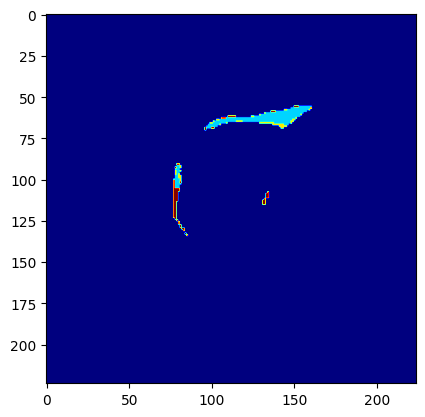

In [26]:
import matplotlib.pyplot as plt

plt.imshow(mask.permute(2, 0, 1)[2, :, :], cmap="jet", alpha=1)